# Experiment: XGB Boost resuming

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
DATA_DIR = Path("data/").resolve()

EXPERIMENT_NAME = "05_xgboost-resuming"

EXPERIMENT_DIR = Path(f"experiments/{EXPERIMENT_NAME}").resolve()

os.makedirs(EXPERIMENT_DIR, exist_ok=True)

In [3]:
training_set = pd.read_csv(DATA_DIR / "training_set.csv", delimiter=",")

training_set_back = training_set.copy()

# Fix outliers. Looks like an error in data entry

training_set.loc[training_set.D3D > 10000, "D3D"] = training_set.D3D / 1000
training_set.loc[training_set.D2D > 10000, "D2D"] = training_set.D2D / 1000
training_set.loc[training_set.AZ > 1000, "AZ"] = training_set.AZ / 1000

In [4]:
features_to_drop = ["ID_FILA", "ID_EVENTO"]

In [5]:
categorical_features = [
    "CAMPO",
    "FLUIDO",
    "HIJO",
    "PAD_HIJO",
    "PADRE",
    "ESTADO",
    "LINEAMIENTO"
]

### Target Encoding + Additive smoothing

In [6]:
smooth_aggs = {}

In [7]:
def calc_smooth_agg(df, by, on, m, metric):
    # Compute the global aggretation

    global_agg = df[on].mean() if metric == "mean" else df[on].median()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', metric])
    counts = agg['count']
    medians = agg[metric]

    # Compute the "smoothed" aggregation (mean/median)
    smooth = (counts * medians + m * global_agg) / (counts + m)

    # Store the smoothed mean for each value of `by`
    smooth_aggs[smooth.index.name] = smooth.to_dict()

In [8]:
for c in categorical_features:
    calc_smooth_agg(training_set, by=c, on='delta_WHP', m=0, metric="mean")

### Preprocessing

In [9]:
from typing import Any, Dict, List

def preprocessing(df: pd.DataFrame, categorical_features: List[str], smooth_aggs: Dict[str, Any]) -> pd.DataFrame:
    df = df.drop(labels=features_to_drop, axis=1)

    df["AZ_sin"] = df["AZ"].transform(lambda x: np.sin(x * (np.pi / 180)))
    df["AZ_cos"] = df["AZ"].transform(lambda x: np.cos(x * (np.pi / 180)))

    df = df.drop(labels=["AZ"], axis=1)

    for c in categorical_features:
        df[c] = df[c].map(smooth_aggs[c])

    return df

In [10]:
training_set = preprocessing(training_set, categorical_features, smooth_aggs)

### XGB Regressor

In [11]:
holdout = training_set.sample(frac=0.1)

training_set = training_set[~training_set.index.isin(holdout.index)]

from sklearn.model_selection import train_test_split

TARGET = "delta_WHP"

X = training_set.drop(TARGET, axis=1)
y = training_set[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

In [12]:
X_train.head()

,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,#_BARRERAS,LINEAMIENTO,WHP_i,ESTADO,AZ_sin,AZ_cos
15177,3.267177,1.530124,1.565198,0.151938,33,0.634028,1002.924024,1002.769860,17.584229,0.0,1.344759,321.3,0.069091,-0.818427,0.574610
21673,1.307696,1.530124,0.283837,0.357143,14,0.107438,916.931257,915.594585,49.492288,0.0,1.344759,193.1,3.913048,0.498812,0.866710
16038,0.445973,0.878385,0.202881,0.004762,25,0.026068,1411.192351,1410.520567,43.538269,0.0,1.344759,369.2,0.069091,-0.987258,0.159130
22134,1.331508,1.530124,0.376543,0.482609,10,0.418644,737.326304,737.280511,-8.217407,0.0,1.344759,224.9,3.913048,0.999311,0.037115
9607,1.307696,1.530124,0.283837,0.498072,62,4.223009,1518.919579,1518.882359,10.633285,2.0,1.344759,69.6,0.069091,-0.999337,-0.036398


In [16]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {
    "booster": "gbtree",
    "objective":"reg:squarederror",
    "eval_metric":["rmse", "mae"],
    "learning_rate":0.01,  # default: 0.1
    "min_split_loss": 0.01,  # default: 0
    "max_depth": 6,  # default: 6
    "n_estimators": 5000,
    "early_stopping_rounds": 100
}

In [17]:
reg = xgb.XGBRegressor(
    **params
)

In [18]:
reg.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=20,
)

[0]	validation_0-rmse:7.75327	validation_0-mae:1.83634	validation_1-rmse:7.21498	validation_1-mae:1.80567
[20]	validation_0-rmse:7.11684	validation_0-mae:1.66698	validation_1-rmse:6.72933	validation_1-mae:1.64986
[40]	validation_0-rmse:6.60955	validation_0-mae:1.54883	validation_1-rmse:6.38148	validation_1-mae:1.55604
[60]	validation_0-rmse:6.21482	validation_0-mae:1.46397	validation_1-rmse:6.11768	validation_1-mae:1.49485
[80]	validation_0-rmse:5.89153	validation_0-mae:1.40305	validation_1-rmse:5.95088	validation_1-mae:1.45571
[100]	validation_0-rmse:5.59332	validation_0-mae:1.34478	validation_1-rmse:5.78978	validation_1-mae:1.41903
[120]	validation_0-rmse:5.33381	validation_0-mae:1.29237	validation_1-rmse:5.63974	validation_1-mae:1.38830
[140]	validation_0-rmse:5.11790	validation_0-mae:1.25192	validation_1-rmse:5.53637	validation_1-mae:1.36755
[160]	validation_0-rmse:4.94077	validation_0-mae:1.21988	validation_1-rmse:5.46852	validation_1-mae:1.35698
[180]	validation_0-rmse:4.78951	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=['rmse', 'mae'], gamma=0.00999999978, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, min_split_loss=0.01, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [19]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
).sort_values("importance", ascending=False)

fi.head(3)

,importance
HIJO,0.154074
D3D,0.150201
#_BARRERAS,0.104247


## Predictions

## Analyze errors in holdout predictions

In [20]:
holdout["preds"] = reg.predict(holdout.drop("delta_WHP", axis=1))

In [21]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(holdout.delta_WHP, holdout.preds)

1.351919798063174

In [22]:
holdout["abs_err"] = holdout["delta_WHP"] - holdout["preds"]

pd.DataFrame([
    holdout.abs_err.describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999])
])

,count,mean,std,min,0.1%,5%,10%,25%,50%,75%,90%,95%,97%,99.9%,max
abs_err,2618.0,-0.137511,5.255134,-83.815851,-34.711933,-3.281142,-1.355229,-0.279786,-0.047934,-0.011995,-0.0025,1.299795,5.070958,46.825806,94.913159


### Target

In [23]:
pd.DataFrame(
    data=[
        training_set.loc[:, "delta_WHP"].describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999]),
        holdout.loc[:, "delta_WHP"].describe(percentiles=[.001, .05, .1, .25, .5, .75, .9, .95, .97, .999]),
    ],
    index=pd.MultiIndex.from_tuples([
        ("Training", "delta_WHP"),
        ("Holdout", "delta_WHP"),
    ], names=("set", "feature"))
)

,,count,mean,std,min,0.1%,5%,10%,25%,50%,75%,90%,95%,97%,99.9%,max
set,feature,,,,,,,,,,,,,,,
Training,delta_WHP,23560.0,1.379724,7.605778,-90.0,-8.6205,0.0,0.0,0.0,0.0,0.0,1.10,7.10,13.123,102.1056,212.8
Holdout,delta_WHP,2618.0,1.339152,7.282831,-42.7,-6.9915,0.0,0.0,0.0,0.0,0.0,0.83,6.83,13.600,82.3534,170.8


Text(0.5, 1.0, 'Dist. of delta_WHP in holdout')

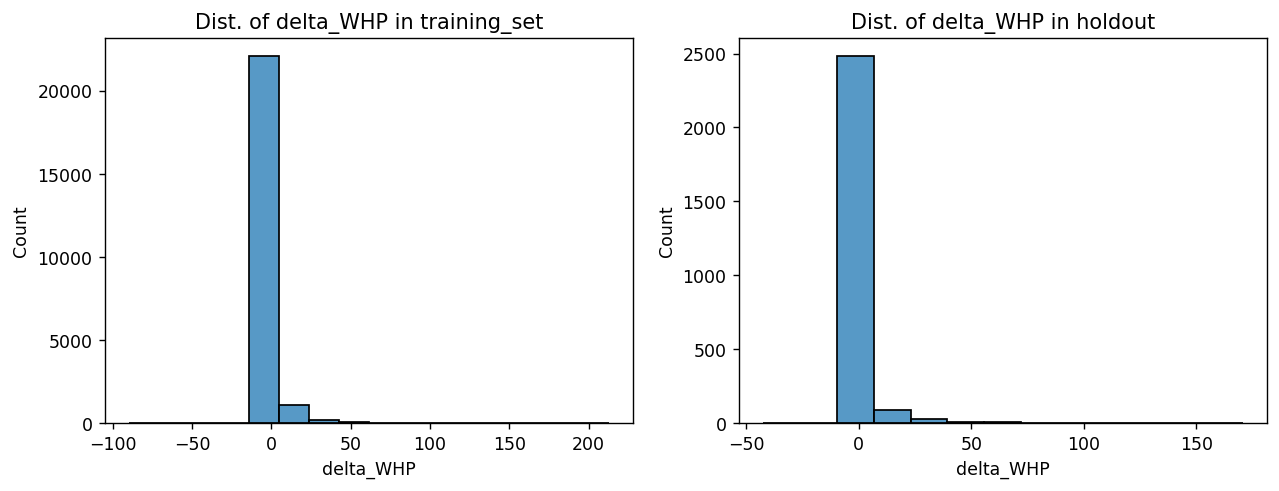

In [24]:
fig, axs = plt.subplots(ncols=2, **{"figsize": (12, 4), "dpi": 125, "facecolor": "white"})

sns.histplot(data=training_set, x="delta_WHP", ax=axs[0]).set_title("Dist. of delta_WHP in training_set")
sns.histplot(data=holdout, x="delta_WHP", ax=axs[1]).set_title("Dist. of delta_WHP in holdout")

### Target according to distances

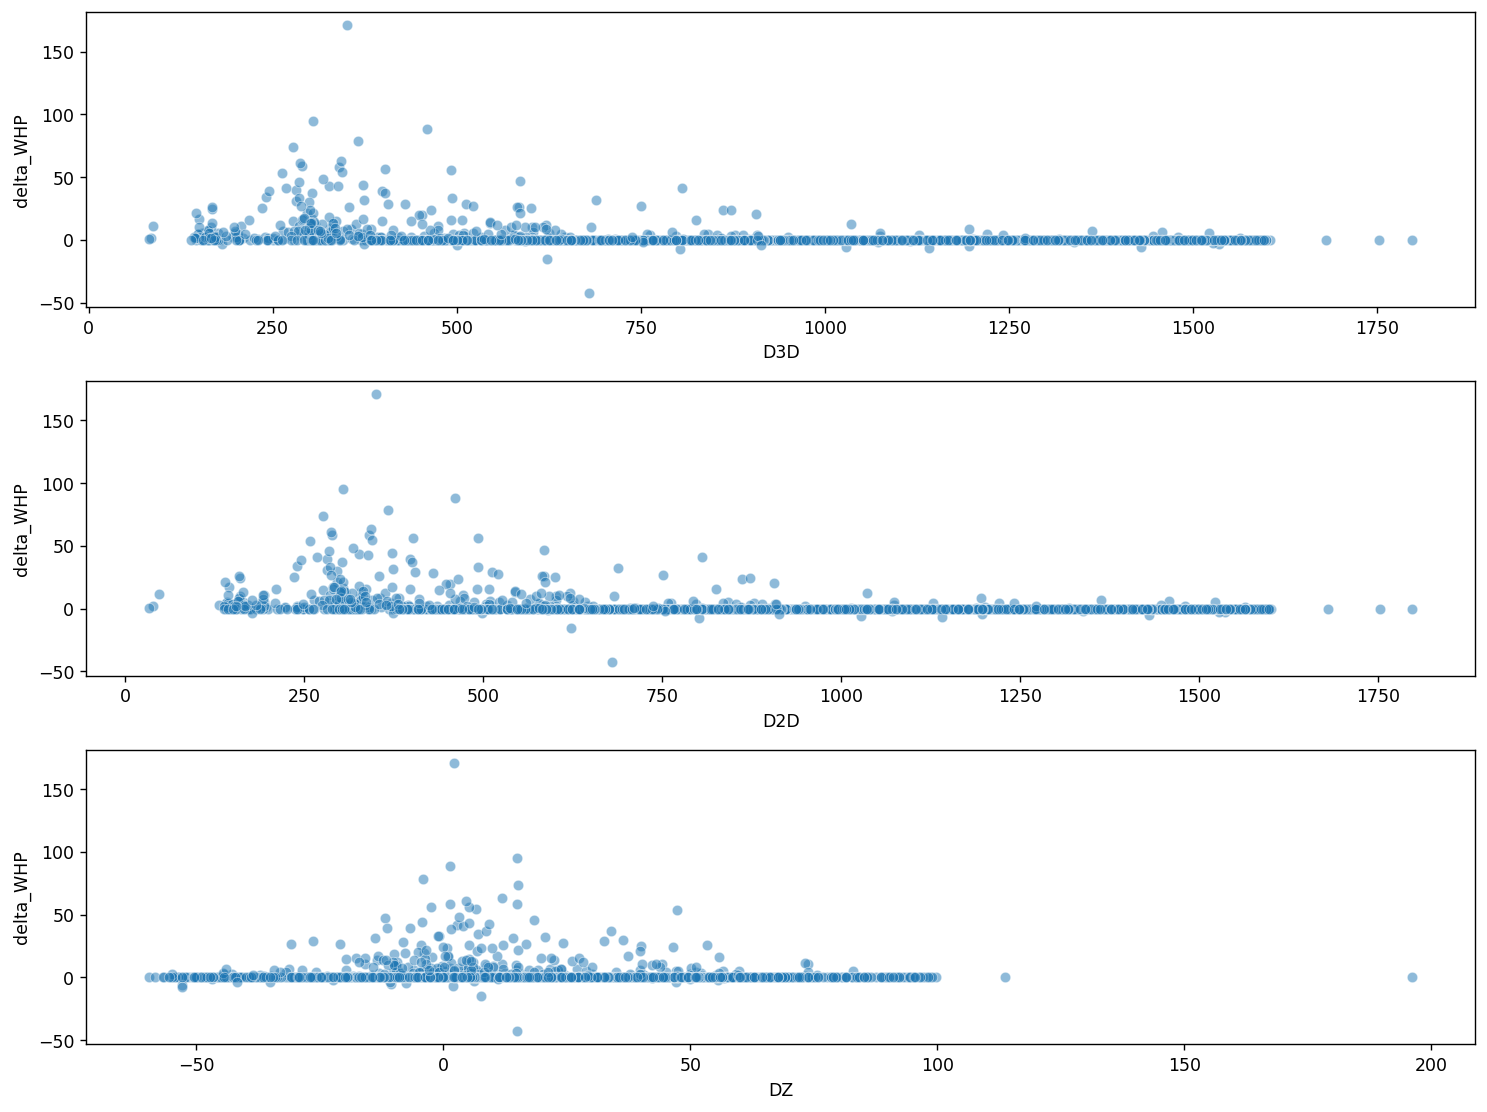

In [25]:
fig, axs = plt.subplots(nrows=3, **{"figsize": (12, 9), "dpi": 125, "facecolor": "white"})

sns.scatterplot(x='D3D', y='delta_WHP',data=holdout[holdout.D3D < 9000], ax=axs[0], alpha=0.5)
sns.scatterplot(x='D2D', y='delta_WHP', data=holdout, ax=axs[1], alpha=0.5)
sns.scatterplot(x='DZ',y='delta_WHP', data=holdout, ax=axs[2], alpha=0.5)

plt.tight_layout()

### Target according to barriers

<AxesSubplot:xlabel='#_BARRERAS', ylabel='delta_WHP'>

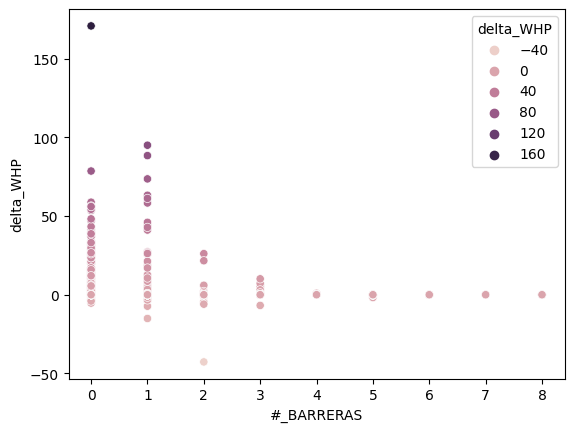

In [26]:
sns.scatterplot(
    data=holdout,
    x="#_BARRERAS",
    y="delta_WHP", hue="delta_WHP"
)

### Target according to AZ

<AxesSubplot:xlabel='AZ_cos', ylabel='AZ_sin'>

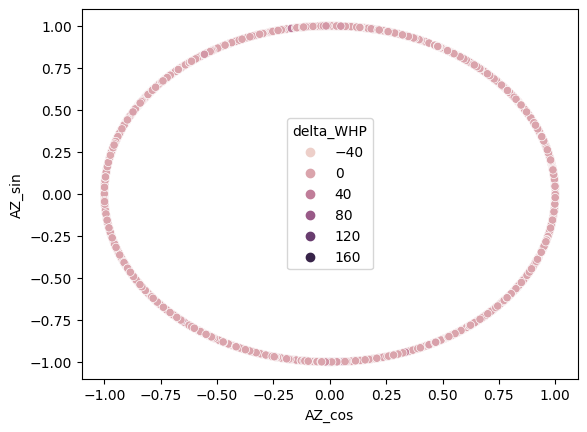

In [27]:
sns.scatterplot(
    data=holdout,
    x="AZ_cos",
    y="AZ_sin", hue="delta_WHP"
)

## Final predictions and submission

In [ ]:
predictions_set = pd.read_csv(DATA_DIR / "predictions_set.csv", delimiter=",")

predictions_set_back = predictions_set.copy()

def predictions_preprocessing(df: pd.DataFrame) -> pd.DataFrame:

    df["D3D"] = df["D3D"].transform(lambda d: d.replace(",", "."))
    df["D3D"] = df["D3D"].astype(float)

    df["WHP_i"] = df["WHP_i"].transform(lambda d: d.replace(",", "."))
    df["WHP_i"] = df["WHP_i"].astype(float)

    df = preprocessing(df, categorical_features, smooth_aggs)

    return df

In [ ]:
predictions_set = predictions_preprocessing(predictions_set)

In [ ]:
predictions_set["delta_WHP"] = reg.predict(predictions_set)

## Submit answer

In [ ]:
raise

In [ ]:
predictions_set = pd.concat([predictions_set_back, predictions_set["delta_WHP"]], axis=1)

In [ ]:
predictions_set.to_csv(
    EXPERIMENT_DIR / "predicciones.csv",
    columns=["ID_FILA", "delta_WHP"],
    header=False,
    index=False,
)

In [ ]:
reg.save_model(EXPERIMENT_DIR / "xgb-model")